In [1]:
%run init.ipynb
from qiskit import *

# Hamiltoniano de Heisenberg XXX
$$H_{xxx} = J\sum_{\langle j,k\rangle}\big(\sigma_{j}^{x}\sigma_{k}^{x}+\sigma_{j}^{y}\sigma_{k}^{y}+\sigma_{j}^{z}\sigma_{k}^{z}\big).$$

## Dinâmica exata para 3 spins
Para uma linha com __3 spins__ teremos
\begin{align}
H_{xxx} = X\otimes X\otimes I + I\otimes X\otimes X + Y\otimes Y\otimes I + I\otimes Y\otimes Y + Z\otimes Z\otimes I + I\otimes Z\otimes Z
\end{align}
<img src = 'fig_3spins.png' width = '300'>

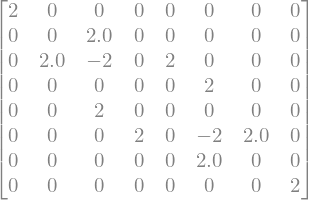

In [47]:
def Hxxx():
    H = tp(tp(pauli(1),pauli(1)),id(2)) + tp(id(2),tp(pauli(1),pauli(1)))\
    + tp(tp(pauli(2),pauli(2)),id(2)) + tp(id(2),tp(pauli(2),pauli(2)))\
    + tp(tp(pauli(3),pauli(3)),id(2)) + tp(id(2),tp(pauli(3),pauli(3)))
    return H
H = Hxxx(); H

In [48]:
#eig

In [49]:
#eig = H.eigenvects(); eig[0], eig[0][0], eig[0][2][0]

$$U = e^{-iHt}$$

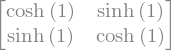

In [50]:
def mat_exp(A):
    d = A.shape[0]; eig = A.eigenvects(); Aexp = zeros(d,d); ne = 0; j = 0; lk = 0
    while ne < d:
        mult = eig[j][1]; ne += mult
        for k in range(0,mult):
            Proj = proj(eig[j][2][k]); Aexp += exp(eig[j][0])*(Proj/trace(Proj))
        j += 1
    return Aexp
simplify(mat_exp(pauli(1)))

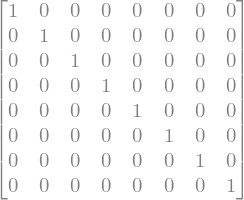

In [5]:
def UHxxx(t):
    H = Hxxx()
    return mat_exp(-1j*t*H)
U = UHxxx(0); U

$$|\psi_{0}\rangle = |110\rangle$$

In [6]:
psi0 = tp(tp(cb(2,1),cb(2,1)),cb(2,0)); #psi0
dt = 0.05; t = np.arange(0, 2*pi+dt, dt); d = len(t); F = np.zeros(d);  psit = psi0
for j in range(0, d):
    U = UHxxx(t[j]); psit = U*psi0
    ip = inner_product(psi0, psit); F[j] = ip*conjugate(ip)
    #print(t[j], F[j])    

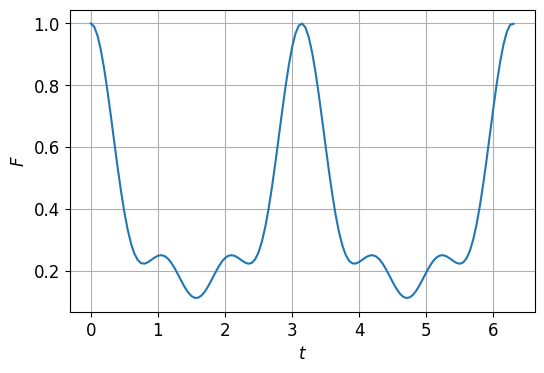

In [7]:
plt.figure(figsize = (6,4), dpi = 100)
plt.plot(t, F); plt.xlabel(r'$t$'); plt.ylabel(r'$F$'); plt.grid(); plt.show()

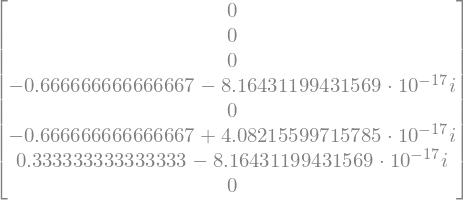

In [11]:
simplify(UHxxx(pi/2)*psi0) # estado com menor fidelidade

Note que a dinâmica, neste caso, é periódica com período igual a $\pi$.

# Trotterização
Considere um Hamiltoniano independente do tempo e que pode ser escrito em termos de dois operadores Hermitianos como segue
$$H = H_{a} + H_{b}.$$
Se $[H_{a},H_{b}]=\mathbb{O}$, temos que
$$U = e^{-iHt} = e^{-iH_{a}t-iH_{b}t} = e^{-iH_{a}t}e^{-iH_{b}t} = U_{b}U_{a} = U_{a}U_{b}.$$
Ou seja, nesse caso a dinâmica total é o simples produto das dinâmicas individuais.
Se $[H_{a},H_{b}]\ne\mathbb{O}$, não podemos usar o simples produto. Mas podemos utilizar a decomposição de Trotter-Suzuki, que lê-se:
$$e^{-iHt} \equiv \lim_{j\rightarrow\infty}\Big(e^{-iH_{a}t/j}e^{-iH_{b}t/j}\Big)^{j}.$$
Ou seja, se dividimos o intervalo de tempo $t$ em um conjunto infinito de intervalos infinitesimais $t/j$, podemos tratar os componentes do Hamiltoniano como se comutassem.

## Escolha da decomposição
Em relação ao Hamiltoniano de 3 spins 1/2 visto acima, podemos definir Hamiltonianos de 2 spins como segue
\begin{align}
H_{xxx}^{12} & = X\otimes X\otimes I + Y\otimes Y\otimes I + Z\otimes Z\otimes I, \\
& = \big(X\otimes X + Y\otimes Y + Z\otimes Z\big)\otimes I, \\
H_{xxx}^{23} &= I\otimes X\otimes X + I\otimes Y\otimes Y + I\otimes Z\otimes Z \\
 & = I\otimes \big(X\otimes X +  Y\otimes Y +  Z\otimes Z\big).
\end{align}
Com isso, vem que
$$H_{xxx} = H_{xxx}^{12} + H_{xxx}^{23}.$$

OBS: Pode-se utilizar diferentes decomposições para testar qual é a melhor. 

OBS: Seria interessante verificar se exite alguma ligação da norma do operador utilizado na decomposição com a fidelidade obtida.

OBS: A testagem referente às duas últimas observações pode ser feita de forma numericamente exata.

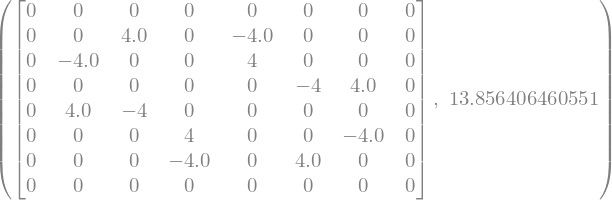

In [12]:
H12 = tp(tp(pauli(1),pauli(1)),id(2)) + tp(tp(pauli(2),pauli(2)),id(2)) + tp(tp(pauli(3),pauli(3)),id(2))
H23 = tp(id(2),tp(pauli(1),pauli(1))) + tp(id(2),tp(pauli(2),pauli(2))) + tp(id(2),tp(pauli(3),pauli(3)))
dH = comm(H12,H23); dH, dH.norm()

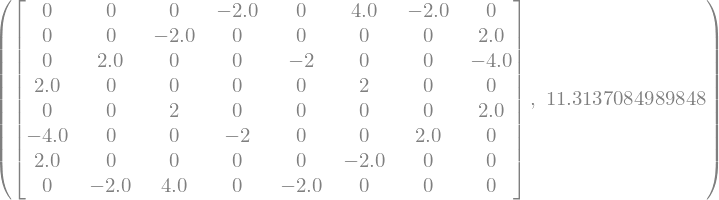

In [13]:
H1 = tp(tp(pauli(1),pauli(1)),id(2)) + tp(id(2),tp(pauli(1),pauli(1))) + tp(id(2),tp(pauli(3),pauli(3)))
H2 = tp(tp(pauli(2),pauli(2)),id(2)) + tp(id(2),tp(pauli(2),pauli(2))) + tp(tp(pauli(3),pauli(3)),id(2))
dH = comm(H1,H2); dH, dH.norm()

No entanto, existe uma __motivação para usarmos a primeira decomposição__. Usando
$$\sigma_{j}\sigma_{k} = \sigma_{0}\delta_{jk}+i\epsilon_{jkl}\sigma_{l},$$
para $j\ne k$, vemos que (usa $(A\otimes B)(C\otimes D)=AC\otimes BD$)
\begin{align}
[\sigma_{j}\otimes\sigma_{j},\sigma_{k}\otimes\sigma_{k}] & = \sigma_{j}\sigma_{k}\otimes\sigma_{j}\sigma_{k} - \sigma_{k}\sigma_{j}\otimes\sigma_{k}\sigma_{j} \\
& = i\epsilon_{jkl}\sigma_{l}\otimes i\epsilon_{jkl}\sigma_{l} -i\epsilon_{kjl}\sigma_{l}\otimes i\epsilon_{kjl}\sigma_{l} \\
& = i^{2}\epsilon_{jkl}^{2}\sigma_{l}\otimes\sigma_{l} -i^{2}\epsilon_{kjl}^{2}\sigma_{l}\otimes \sigma_{l} \\
& = i^{2}\epsilon_{jkl}^{2}\sigma_{l}\otimes\sigma_{l} -i^{2}(-\epsilon_{jkl})^{2}\sigma_{l}\otimes \sigma_{l} \\
& = \mathbb{O}.
\end{align}
Ou seja,
$$[X\otimes X,Y\otimes Y] = [X\otimes X,Z\otimes Z] = [Y\otimes Y,Z\otimes Z] =\mathbb{O}.$$

OBS: Isso não é estranho do ponto de vista de medida simultânea de $\sigma_{j}\otimes\sigma_{j}$ e $\sigma_{k}\otimes\sigma_{k}$? Pense em como essas medidas são feitas no IBMQ ... Note também que $\sigma_{j}$ e $\sigma_{k}$ não são compatíveis para $j\ne k$. Como implementar a medida simultânea de $\sigma_{j}\otimes\sigma_{j}$ e $\sigma_{k}\otimes\sigma_{k}$?

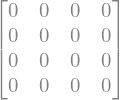

In [14]:
comm(tp(pauli(1),pauli(1)),tp(pauli(2),pauli(2)))

Com isso, vem que
\begin{align}
e^{-iH_{xxx}^{12}t} & = e^{-it(X\otimes X\otimes I + Y\otimes Y\otimes I + Z\otimes Z\otimes I)} \\
& = e^{-itX\otimes X\otimes I}e^{-itY\otimes Y\otimes I}e^{-itZ\otimes Z\otimes I} \\
& = \Big(e^{-itX\otimes X}\otimes I\Big)\Big(e^{-itY\otimes Y}\otimes I\Big)\Big(e^{-itZ\otimes Z}\otimes I\Big), \\
& = \Big(e^{-itX\otimes X}\Big)\Big(e^{-itY\otimes Y}\Big)\Big(e^{-itZ\otimes Z}\Big)\otimes I, \\
e^{-iH_{xxx}^{23}t} &= I\otimes\Big( e^{-itX\otimes X}\Big)\Big( e^{-itY\otimes Y}\Big)\Big( e^{-itZ\otimes Z}\Big),
\end{align}
em que usamos e.g. que 
$$e^{A\otimes I} = e^{A}\otimes I.$$

Com isso teremos
\begin{align}
U & = e^{-iH_{xxx}t} = e^{-i(H_{xxx}^{12}+H_{xxx}^{23})t} = \lim_{j\rightarrow\infty}\Big(e^{-iH_{xxx}^{12}t/j}e^{-iH_{xxx}^{23}t/j}\Big)^{j} \\
& = \lim_{j\rightarrow\infty}\left(\Big(e^{-iX\otimes Xt/j}e^{-iY\otimes Yt/j}e^{-iZ\otimes Zt/j}\otimes I\Big)\Big(I\otimes e^{-iX\otimes Xt/j}e^{-iY\otimes Yt/j}e^{-iZ\otimes Zt/j}\Big)\right)^{j}.
\end{align}

## Efeito do número de passos de Trotter (cálculo "exato")
No desafio da IBM, deve-se usar um mínimo de $j=4$ passos na Trotterização. Teremos assim as aproximações
\begin{align}
U_{1} & = e^{-iH_{xxx}^{12}t/1}e^{-iH_{xxx}^{23}t/1} = B_{1}^{1}, \\
U_{2} & = e^{-iH_{xxx}^{12}t/2}e^{-iH_{xxx}^{23}t/2}e^{-iH_{xxx}^{12}t/2}e^{-iH_{xxx}^{23}t/2} = B_{2}^{2}, \\
U_{3} & = e^{-iH_{xxx}^{12}t/3}e^{-iH_{xxx}^{23}t/3}e^{-iH_{xxx}^{12}t/3}e^{-iH_{xxx}^{23}t/3}e^{-iH_{xxx}^{12}t/3}e^{-iH_{xxx}^{23}t/3} = B_{3}^{3}, \\
U_{4} & = e^{-iH_{xxx}^{12}t/4}e^{-iH_{xxx}^{23}t/4}e^{-iH_{xxx}^{12}t/4}e^{-iH_{xxx}^{23}t/4}e^{-iH_{xxx}^{12}t/4}e^{-iH_{xxx}^{23}t/4}e^{-iH_{xxx}^{12}t/4}e^{-iH_{xxx}^{23}t/4}  = B_{4}^{4} \\
U_{5} & = e^{-iH_{xxx}^{12}t/5}e^{-iH_{xxx}^{23}t/5}e^{-iH_{xxx}^{12}t/5}e^{-iH_{xxx}^{23}t/5}e^{-iH_{xxx}^{12}t/5}e^{-iH_{xxx}^{23}t/5}e^{-iH_{xxx}^{12}t/5}e^{-iH_{xxx}^{23}t/5}e^{-iH_{xxx}^{12}t/5}e^{-iH_{xxx}^{23}t/5}  = B_{5}^{5}, \\
& \vdots.
\end{align}
Ou seja, para $j$ passos de Trotter, teremos a aproximação
$$U_{j} = B_{j}^{j} = \Pi_{k=1}^{j}B_{j}$$
com 
$$B_{j} = e^{-iH_{xxx}^{12}t/j}e^{-iH_{xxx}^{23}t/j}.$$

In [15]:
def Hxxx12():
    H = tp(pauli(1),pauli(1)) + tp(pauli(2),pauli(2)) + tp(pauli(3),pauli(3))
    return tp(H,id(2))
def Hxxx23():
    H = tp(pauli(1),pauli(1)) + tp(pauli(2),pauli(2)) + tp(pauli(3),pauli(3))
    return tp(id(2),H)
def UHxxx12(t):
    H = Hxxx12()
    return mat_exp(-1j*t*H)
def UHxxx23(t):
    H = Hxxx23()
    return mat_exp(-1j*t*H)

In [16]:
dt = 0.05; t = np.arange(0, 2*pi+dt, dt); d = len(t)
F1 = np.zeros(d); F2 = np.zeros(d); F3 = np.zeros(d); F4 = np.zeros(d); F5 = np.zeros(d)
psit1 = psi0; psit2 = psi0; psit3 = psi0; psit4 = psi0; psit5 = psi0
for j in range(0, d):
    U12 = UHxxx12(t[j]); U23 = UHxxx23(t[j]); U1 = U12*U23; psit1 = U1*psi0
    ip = inner_product(psi0,psit1); F1[j] = ip*conjugate(ip)
    #U12 = UHxxx12(t[j]/2); U23 = UHxxx23(t[j]/2); U2 = U12*U23*U12*U23; psit2 = U2*psi0
    #ip = inner_product(psi0,psit2); F2[j] = ip*conjugate(ip)
    #U12 = UHxxx12(t[j]/3); U23 = UHxxx23(t[j]/3); U3 = U12*U23*U12*U23*U12*U23; psit3 = U3*psi0
    #ip = inner_product(psi0,psit3); F3[j] = ip*conjugate(ip)
    #U12 = UHxxx12(t[j]/4); U23 = UHxxx23(t[j]/4); U4 = U12*U23*U12*U23*U12*U23*U12*U23; psit4 = U4*psi0
    #ip = inner_product(psi0,psit4); F4[j] = ip*conjugate(ip)
    #U12 = UHxxx12(t[j]/5); U23 = UHxxx23(t[j]/5); U5 = U12*U23*U12*U23*U12*U23*U12*U23*U12*U23; psit5 = U5*psi0
    #ip = inner_product(psi0,psit5); F5[j] = ip*conjugate(ip)

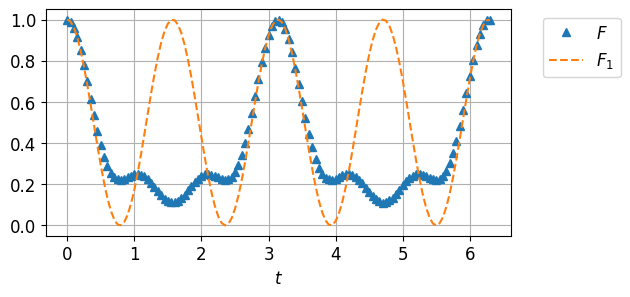

In [19]:
plt.figure(figsize = (6,3), dpi = 100)
plt.plot(t, F, '^', label = r'$F$'); plt.plot(t, F1, '--', label = r'$F_{1}$')
#plt.plot(t, F2, '-.', label = r'$F_{2}$'); plt.plot(t, F3, ':', label = r'$F_{3}$')
#plt.plot(t, F4, '.', label = r'$F_{4}$'); plt.plot(t, F5, '*', label = r'$F_{5}$')
plt.xlabel(r'$t$'); plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid(); plt.show()
# esse cálculo "simbólico" demora muito. Melhor usar o numpy!

## Implementação usando numpy e scipy

In [20]:
# matrizes de Pauli
I = np.array([[1,0],[0,1]]); #print(I)
X = np.array([[0,1],[1,0]]); #print(X)
Y = np.array([[0,-1j],[1j,0]]);# print(Y)
Z = np.array([[1,0],[0,-1]]); #print(Z)

In [21]:
def Hxxx_num():
    H = np.kron(np.kron(X,X),I) + np.kron(I,np.kron(X,X))\
    + np.kron(np.kron(Y,Y),I) + np.kron(I,np.kron(Y,Y))\
    + np.kron(np.kron(Z,Z),I) + np.kron(I,np.kron(Z,Z))
    return H
H = Hxxx_num(); print(H.real)

[[ 2.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.  0.  0.  0.]
 [ 0.  2. -2.  0.  2.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  2.  0.  0.]
 [ 0.  0.  2.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  0. -2.  2.  0.]
 [ 0.  0.  0.  0.  0.  2.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  2.]]


In [22]:
# para calcular a função de matriz (teve problemas de pequenas oscilações)
def proj_num(psi): 
    #return np.outer(psi, np.ndarray.conjugate(psi))
    d = len(psi); proj = np.zeros((d, d), dtype = complex)
    for j in range(0, d):
        for k in range(0, d):
            proj[j,k] = psi[j]*np.conj(psi[k])
    return proj
proj_num(np.array([[1],[1j]]))

array([[1.+0.j, 0.-1.j],
       [0.+1.j, 1.+0.j]])

In [23]:
import cmath
#from math import e
# para calcular a função de matriz (teve problemas de pequenas oscilações)
def mat_exp_num(A): 
    d = A.shape[0]; Aexp = np.zeros((d,d), dtype = complex); 
    eva, eve = np.linalg.eig(A);
    # eva, eve = scipy.linalg.eig(A)
    for j in range(0, d):
        Aexp += cmath.exp(eva[j])*proj_num(eve[:,j])
        #Aexp += e**(eva[j])*proj_num(eve[:,j])
    return Aexp
mat_exp_num(Y)

array([[1.54308063+0.j        , 0.        -1.17520119j],
       [0.        +1.17520119j, 1.54308063+0.j        ]])

In [25]:
def UHxxx_num(t):
    H = Hxxx_num()
    #return mat_exp_num(-1j*t*H)
    return scipy.linalg.expm(-1j*t*H) # resolveu o problema das pequenas flutuações
U = UHxxx_num(0*math.pi); U.real

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [26]:
def ip_num(a, b):
    d = len(a); ip = 0
    for j in range(0, d):
        ip += np.conj(a[j])*b[j]
    return ip
a = np.array([[1],[1j]]); b = np.array([[1],[1j]]); ip_num(a, b)

array([2.+0.j])

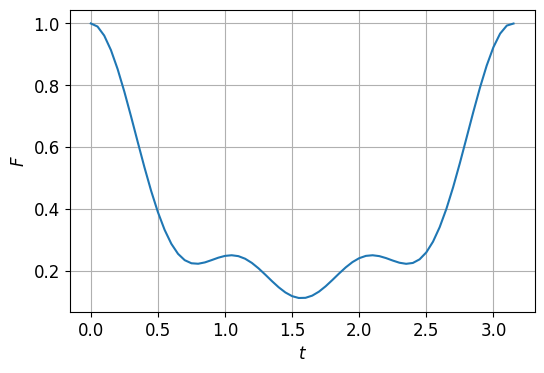

In [57]:
ket0 = np.array([[1],[0]]); ket1 = np.array([[0],[1]]); #ket0, ket1
dt = 0.05; t = np.arange(0, math.pi+dt, dt); d = len(t); F = np.zeros(d);  psit = np.zeros(d, dtype = complex)
psi0_ = np.zeros(d, dtype = complex); psi0_ = np.kron(ket1, np.kron(ket1, ket0)); #psi0
for j in range(0, d):
    U = UHxxx_num(t[j]); psit = np.dot(U, psi0_)
    ip = ip_num(psi0_, psit); F[j] = np.abs(ip)**2
plt.figure(figsize = (6,4), dpi = 100)
plt.plot(t, F); plt.xlabel(r'$t$'); plt.ylabel(r'$F$'); plt.grid(); plt.show()

In [28]:
H2 = np.kron(X, X) + np.kron(Y, Y) + np.kron(Z, Z)
def UHxxx12_num(t):
    H = np.kron(H2, I)
    return scipy.linalg.expm(-1j*t*H)
def UHxxx23_num(t):
    H = np.kron(I, H2)
    return scipy.linalg.expm(-1j*t*H)

In [58]:
dt = 0.05; t = np.arange(0, math.pi+dt, dt); d = len(t)
#F = np.zeros(d); 
F1 = np.zeros(d); F2 = np.zeros(d); F3 = np.zeros(d); F4 = np.zeros(d); F5 = np.zeros(d)
F6 = np.zeros(d); F7 = np.zeros(d); F8 = np.zeros(d); F9 = np.zeros(d); F10 = np.zeros(d); F11 = np.zeros(d)
#psi0_ = np.zeros(d, dtype = complex); 
psi0_ = np.kron(ket1, np.kron(ket1, ket0))
for j in range(0, d):
    U12 = UHxxx12_num(t[j]); U23 = UHxxx23_num(t[j])
    B = np.dot(U12, U23); U1 = np.linalg.matrix_power(B, 1); psit1 = np.dot(U1, psi0_)
    ip = ip_num(psi0_, psit1); F1[j] = np.abs(ip)**2
    U12 = UHxxx12_num(t[j]/2); U23 = UHxxx23_num(t[j]/2)
    B = np.dot(U12, U23); U2 = np.linalg.matrix_power(B, 2); psit2 = np.dot(U2, psi0_)
    ip = ip_num(psi0_, psit2); F2[j] = np.abs(ip)**2
    U12 = UHxxx12_num(t[j]/3); U23 = UHxxx23_num(t[j]/3)
    B = np.dot(U12, U23); U3 = np.linalg.matrix_power(B, 3); psit3 = np.dot(U3, psi0_)
    ip = ip_num(psi0_, psit3); F3[j] = np.abs(ip)**2
    U12 = UHxxx12_num(t[j]/4); U23 = UHxxx23_num(t[j]/4)
    B = np.dot(U12, U23); U4 = np.linalg.matrix_power(B, 4); psit4 = np.dot(U4, psi0_)
    ip = ip_num(psi0_, psit4); F4[j] = np.abs(ip)**2
    U12 = UHxxx12_num(t[j]/5); U23 = UHxxx23_num(t[j]/5)
    B = np.dot(U12, U23); U5 = np.linalg.matrix_power(B, 5); psit5 = np.dot(U5, psi0_)
    ip = ip_num(psi0_, psit5); F5[j] = np.abs(ip)**2
    U12 = UHxxx12_num(t[j]/6); U23 = UHxxx23_num(t[j]/6)
    B = np.dot(U12, U23); U6 = np.linalg.matrix_power(B, 6); psit6 = np.dot(U6, psi0_)
    ip = ip_num(psi0_, psit6); F6[j] = np.abs(ip)**2
    U12 = UHxxx12_num(t[j]/7); U23 = UHxxx23_num(t[j]/7)
    B = np.dot(U12, U23); U7 = np.linalg.matrix_power(B, 7); psit7 = np.dot(U7, psi0_)
    ip = ip_num(psi0_, psit7); F7[j] = np.abs(ip)**2
    U12 = UHxxx12_num(t[j]/8); U23 = UHxxx23_num(t[j]/8)
    B = np.dot(U12, U23); U8 = np.linalg.matrix_power(B, 8); psit8 = np.dot(U8, psi0_)
    ip = ip_num(psi0_, psit8); F8[j] = np.abs(ip)**2
    U12 = UHxxx12_num(t[j]/9); U23 = UHxxx23_num(t[j]/9)
    B = np.dot(U12, U23); U9 = np.linalg.matrix_power(B, 9); psit9 = np.dot(U9, psi0_)
    ip = ip_num(psi0_, psit9); F9[j] = np.abs(ip)**2
    U12 = UHxxx12_num(t[j]/10); U23 = UHxxx23_num(t[j]/10)
    B = np.dot(U12, U23); U10 = np.linalg.matrix_power(B, 10); psit10 = np.dot(U10, psi0_)
    ip = ip_num(psi0_, psit10); F10[j] = np.abs(ip)**2
    U12 = UHxxx12_num(t[j]/11); U23 = UHxxx23_num(t[j]/11)
    B = np.dot(U12, U23); U11 = np.linalg.matrix_power(B, 11); psit11 = np.dot(U11, psi0_)
    ip = ip_num(psi0_, psit11); F11[j] = np.abs(ip)**2
    if j == d-1:
        print('F5 = ', F5[j], ', F6 = ', F6[j])

F5 =  0.2577536303224352 , F6 =  0.5765991261868874


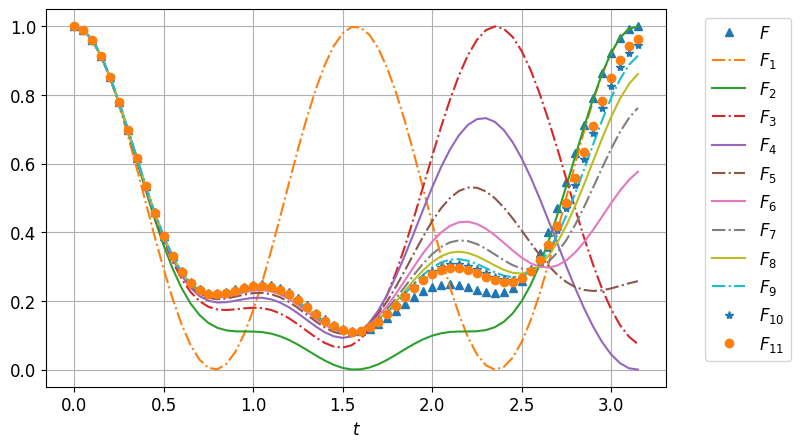

In [64]:
plt.figure(figsize = (8,5), dpi = 100)
plt.plot(t, F, '^', label = r'$F$'); 
plt.plot(t, F1, '-.', label = r'$F_{1}$')
plt.plot(t, F2, '', label = r'$F_{2}$'); plt.plot(t, F3, '-.', label = r'$F_{3}$')
plt.plot(t, F4, '', label = r'$F_{4}$'); plt.plot(t, F5, '-.', label = r'$F_{5}$')
plt.plot(t, F6, '', label = r'$F_{6}$'); plt.plot(t, F7, '-.', label = r'$F_{7}$')
plt.plot(t, F8, '', label = r'$F_{8}$'); plt.plot(t, F9, '-.', label = r'$F_{9}$')
plt.plot(t, F10, '*', label = r'$F_{10}$'); plt.plot(t, F11, 'o', label = r'$F_{11}$')
plt.xlabel(r'$t$'); plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid(); plt.show()

Vemos que, de forma análoga à teoria de perturbação da MQ, na Trotterização não há obrigatoriamente uma melhora na aproximação conforme adicionamos um passo de Trotter. Vemos que para o tempo que nos interessa aqui, 
$$t=\pi,$$
temos, por exemplo, menor fidelidade para 4 passos de Trotter que para 3 passos: 
$$F_{4}(t=\pi)<F_{3}(t=\pi).$$
Na verdade, mesmo no caso exato, vemos que o número mínimo de passos de Trotter que precisamos usar para conseguir passar da fidelidade mínima exigida,
$$F_{\min} = 0.3,$$
deve ser 
$$j_{\min} = 6 \ \therefore\ F_{6}(t=\pi)\approx 0.5766,$$
já que
$$F_{5}(t=\pi)\approx 0.2577.$$
Notamos que depois de um certo número de passos de Trotter, digamos $n=9$, a curva aproximada se aproxima muito lentamente da curva exata, indicando que para conseguir um resultado bem próximo do exato, teríamos que aumentar muito o número de passos de Trotter.

## Sobre a simulação e experimento
* $e^{-itZZ}$ <br>
Primeiramente, notemos que ($ZZ\equiv Z\otimes Z$ e $|jk\rangle\equiv|j\rangle\otimes|k\rangle$)
\begin{cases}
ZZ|00\rangle = |00\rangle, \\
ZZ|01\rangle = -|01\rangle, \\
ZZ|10\rangle = -|10\rangle, \\
ZZ|11\rangle = |11\rangle.
\end{cases}
Ou seja, a ação de $ZZ$ na base computacional depende da paridade do estado.
Notando que $Z=|0\rangle\langle 0|-|1\rangle\langle 1|$, vemos que
\begin{align}
ZZ & \equiv Z\otimes Z = (|0\rangle\langle 0|-|1\rangle\langle 1|)\otimes(|0\rangle\langle 0|-|1\rangle\langle 1|) \\
& = |00\rangle\langle 00| - |01\rangle\langle 01| - |10\rangle\langle 10| + |11\rangle\langle 11|.
\end{align}
Assim
\begin{align}
e^{-itZZ} & = \begin{bmatrix} e^{-it} & 0 & 0 & 0 \\ 0 & e^{it} & 0 & 0 \\ 0 & 0 & e^{it} & 0 \\ 0 & 0 & 0 & e^{-it}  \end{bmatrix} \\
& = e^{-it}(|00\rangle\langle 00|+|11\rangle\langle 11|) + e^{it}(|01\rangle\langle 01|+|10\rangle\langle 10|).
\end{align}
Ou seja, quando atua na base computacional, $e^{-itZZ}$ multiplica estados com paridade par por $ e^{-it}$ enquanto que estados com paridade ímpar são multiplicados por $e^{it}$.

Pode-se verificar também que
\begin{align}
C_{x}^{01}\big(I\otimes e^{-itZ}\big)C_{x}^{01} & = C_{x}^{01}\big(I\otimes e^{-itZ}\big)\big(|0\rangle\langle 0|\otimes I +|1\rangle\langle 1|\otimes X \big) \\
& = \big(|0\rangle\langle 0|\otimes I +|1\rangle\langle 1|\otimes X \big)\big(|0\rangle\langle 0|\otimes e^{-itZ} +|1\rangle\langle 1|\otimes e^{-itZ}X \big) \\
& = |0\rangle\langle 0|\otimes e^{-itZ} +|1\rangle\langle 1|\otimes Xe^{-itZ}X \\
& = |0\rangle\langle 0|\otimes \big(e^{-it}|0\rangle\langle 0|+e^{it}|1\rangle\langle 1|\big) +|1\rangle\langle 1|\otimes X \big(e^{-it}|0\rangle\langle 0|+e^{it}|1\rangle\langle 1|\big)X \\
& = |0\rangle\langle 0|\otimes \big(e^{-it}|0\rangle\langle 0|+e^{it}|1\rangle\langle 1|\big) +|1\rangle\langle 1|\otimes \big(e^{-it}|1\rangle\langle 1|+e^{it}|0\rangle\langle 0|\big) \\
& = e^{-it}|00\rangle\langle 00| + e^{it}|01\rangle\langle 01| + e^{-it}|11\rangle\langle 11| + e^{it}|10\rangle\langle 10| \\
& = e^{-itZZ}.
\end{align}

A porta lógica denominada rotação em torno de $z$ do qiskit é
$$RZ(\lambda) = e^{-i\lambda Z/2}.$$
Portanto
$$e^{-itZ} = e^{-i2tZ/2} = RZ(2t)$$
e
$$e^{-itZZ} = C_{x}^{01}\big(I\otimes RZ(2t)\big)C_{x}^{01}.$$

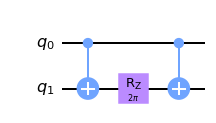

In [31]:
def qc_ezz(t):
    qc = QuantumCircuit(2, name = 'e^(-itZZ)')
    qc.cx(0, 1); qc.rz(2*t, 1); qc.cx(0, 1) 
    return qc
qc_ezz_ = qc_ezz(math.pi); qc_ezz_.draw(output='mpl')

* $e^{-itXX}$ <br>
Começamos notando que $X=|+\rangle\langle +|-|-\rangle\langle -|$, com $|\pm\rangle = (|0\rangle\pm|1\rangle)/\sqrt{2}$. Assim, temos que
$$XX = X\otimes X = (|++\rangle\langle ++|+|--\rangle\langle --|)-(|+-\rangle\langle +-|+|-+\rangle\langle -+|).$$
Assim (usa $|+\rangle = H|0\rangle$ e $|-\rangle = H|1\rangle$)
\begin{align}
e^{-itXX} & = e^{-it}(|++\rangle\langle ++|+|--\rangle\langle --|)+e^{it}(|+-\rangle\langle +-|+|-+\rangle\langle -+|) \\
& = e^{-it}(HH|00\rangle\langle 00|HH+HH|11\rangle\langle 11|HH)+e^{it}(HH|01\rangle\langle 01|HH+HH|10\rangle\langle 10|HH) \\
& = HH\Big(e^{-it}(|00\rangle\langle 00|+|11\rangle\langle 11|)+e^{it}(|01\rangle\langle 01|+|10\rangle\langle 10|)\Big)HH \\
& = HHe^{-itZZ}HH \\
& = HHC_{x}^{01}\big(I\otimes e^{-itZ}\big)C_{x}^{01}HH \\
&  = (H\otimes H)C_{x}^{01}\big(I\otimes RZ(2t)\big)C_{x}^{01}(H\otimes H).
\end{align}

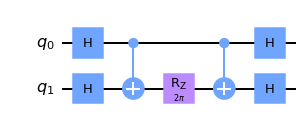

In [32]:
def qc_exx(t):
    qc = QuantumCircuit(2, name = 'e^(-itXX)')
    qc.h([0,1]); qc.cx(0, 1); qc.rz(2*t, 1); qc.cx(0, 1); qc.h([0,1])
    #qc.h([0,1]); qc_ezz_ = qc_ezz(t); qc.append(qc_ezz_, [0, 1]); qc.h([0,1])
    return qc
qc_exx_ = qc_exx(math.pi); qc_exx_.draw(output='mpl')

In [ ]:
#qc_exx_.decompose().draw(output='mpl')

* $e^{-itYY}$ <br>
Começamos notando que $Y=|\oplus\rangle\langle \oplus|-|\ominus\rangle\langle \ominus|$, com $|\oplus\rangle = (|0\rangle+i|1\rangle)/\sqrt{2}$ e $|\ominus\rangle = (|0\rangle-i|1\rangle)/\sqrt{2}$. Assim, temos que
$$YY = (|\oplus\oplus\rangle\langle \oplus\oplus|+|\ominus\ominus\rangle\langle \ominus\ominus|)-(|\oplus\ominus\rangle\langle \oplus\ominus|+|\ominus\oplus\rangle\langle \ominus\oplus|).$$
Assim (usa $|\oplus\rangle = SH|0\rangle$ e $|\ominus\rangle = SH|1\rangle$)
\begin{align}
e^{-itYY} & = e^{-it}(|\oplus\oplus\rangle\langle \oplus\oplus|+|\ominus\ominus\rangle\langle \ominus\ominus|) + e^{it}(|\oplus\ominus\rangle\langle \oplus\ominus|+|\ominus\oplus\rangle\langle \ominus\oplus|) \\
& = (SS)(HH)\Big(e^{-it}(|00\rangle\langle 00|+|11\rangle\langle 11|)+e^{it}(|01\rangle\langle 01|+|10\rangle\langle 10|)\Big)(HH)(S^{\dagger}S^{\dagger}) \\
& = (S\otimes S)(H\otimes H)e^{-itZZ}(H\otimes H)(S^{\dagger}\otimes S^{\dagger}) \\
& = (S\otimes S)e^{-itXX}(S^{\dagger}\otimes S^{\dagger}) \\
& = (S\otimes S)(H\otimes H)C_{x}^{01}\big(I\otimes e^{-itZ}\big)C_{x}^{01}(H\otimes H)(S^{\dagger}\otimes S^{\dagger}) \\
& = (S\otimes S)(H\otimes H)C_{x}^{01}\big(I\otimes RZ(2t)\big)C_{x}^{01}(H\otimes H)(S^{\dagger}\otimes S^{\dagger}).
\end{align}

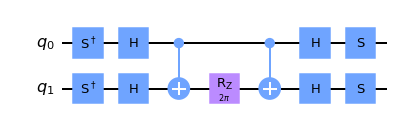

In [33]:
def qc_eyy(t):
    qc = QuantumCircuit(2, name = 'e^(-itYY)')
    qc.sdg([0,1]); qc.h([0,1]); qc.cx(0, 1); qc.rz(2*t, 1); qc.cx(0, 1); qc.h([0,1]); qc.s([0,1])
    #qc.sdg([0,1]); qc_exx_ = qc_exx(t); qc.append(qc_exx_, [0, 1]); qc.s([0,1])
    return qc
qc_eyy_ = qc_eyy(math.pi); qc_eyy_.draw(output='mpl')

In [ ]:
#qc_eyy_.decompose().draw(output='mpl')

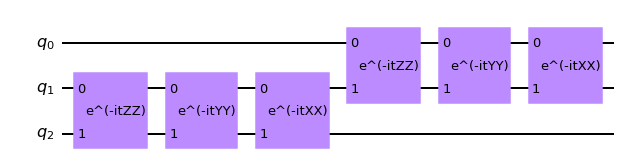

In [34]:
def qc_Bj(t):
    qc = QuantumCircuit(3, name = 'B_j')
    qc_ezz_ = qc_ezz(t); qc_eyy_ = qc_eyy(t); qc_exx_ = qc_exx(t)
    qc.append(qc_ezz_, [1, 2]); qc.append(qc_eyy_, [1, 2]); qc.append(qc_exx_, [1, 2])
    qc.append(qc_ezz_, [0, 1]); qc.append(qc_eyy_, [0, 1]); qc.append(qc_exx_, [0, 1])
    return qc
qc_Bj_ = qc_Bj(math.pi/2); qc_Bj_.draw(output='mpl')

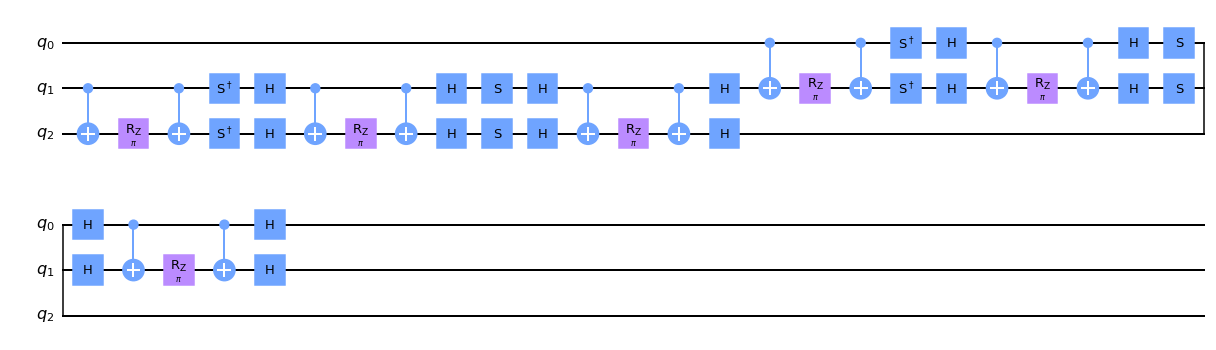

In [35]:
qc_Bj_.decompose().draw(output='mpl')

Nesse ponto, é natural nos perguntarmos se temos ou não liberdade para mudar a ordem de algums operações para evitar aplicar operações redundantes. Relacionado a isso, observo e.g. que
$$e^{-itX\otimes X\otimes I}e^{-itI\otimes Z\otimes Z} \ne e^{-itI\otimes Z\otimes Z}e^{-itX\otimes X\otimes I}$$
pois, para $j\ne k$, temos
\begin{align}
[\sigma_{j}\otimes\sigma_{j}\otimes\sigma_{0},\sigma_{0}\otimes\sigma_{k}\otimes\sigma_{k}] & = (\sigma_{j}\otimes\sigma_{j}\otimes\sigma_{0})(\sigma_{0}\otimes\sigma_{k}\otimes\sigma_{k}) - (\sigma_{0}\otimes\sigma_{k}\otimes\sigma_{k})(\sigma_{j}\otimes\sigma_{j}\otimes\sigma_{0}) \\
& = \sigma_{j}\otimes\sigma_{j}\sigma_{k}\otimes\sigma_{k} - \sigma_{j}\otimes\sigma_{k}\sigma_{j}\otimes\sigma_{k} \\
& = \sigma_{j}\otimes i\epsilon_{jkl}\sigma_{l}\otimes\sigma_{k} - \sigma_{j}\otimes i\epsilon_{kjl}\sigma_{l}\otimes\sigma_{k} \\
& = 2i\epsilon_{jkl}\sigma_{j}\otimes\sigma_{l}\otimes\sigma_{k} \\
& \ne \mathbb{O}.
\end{align}

##### Fidelidade entre um estado puro e um estado misto:
\begin{align}
F(\rho,\psi) = \langle\psi|\rho|\psi\rangle = \sum_{j,k=0}^{d-1}\psi_{j}^{*}\rho_{j,k}\psi_{k}.
\end{align}

In [44]:
def F_psi_rho_num(psi, rho):
    d = rho.shape[0]; F = 0
    for j in range(0, d):
        for k in range(0, d):
            F += np.conj(psi[j])*rho[j,k]*psi[k]
    return F.real
psi = [1/math.sqrt(2),1j/math.sqrt(2)]; rho = 0.5*np.array([[1,-1j],[1j,1]])
F = F_psi_rho_num(psi, rho); print(F) # ok!

0.9999999999999998


In [37]:
nshots = 8192
qiskit.IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
#device = provider.get_backend('ibmq_jakarta')
provider = qiskit.IBMQ.get_provider(hub = 'ibm-q-research-2', group = 'federal-uni-sant-1', project = 'main')
device = provider.get_backend('ibmq_bogota')
simulator = Aer.get_backend('qasm_simulator')
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.tools.monitor import backend_overview, backend_monitor

In [66]:
#backend_overview()
3360/3

In [38]:
def qc_psi0():
    qc = QuantumCircuit(3, name = 'psi0')
    qc.x([0,1])
    return qc
qc_psi0_ = qc_psi0(); qc_psi0_.draw()

┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────

In [ ]:
#psi0__ = [0, 0, 0, 0, 0, 0, 1, 0]; 
# troca a ordem, |110> -> |011>, por causa da ordem dos qubits que vem da tomografia

In [45]:
dt = 0.2; t = np.arange(0, math.pi+dt, dt); d = len(t)
Ft = np.zeros(d); Fs = np.zeros(d); Fe = np.zeros(d)
for j in range(0, d):
    U12 = UHxxx12_num(t[j]/1); U23 = UHxxx23_num(t[j]/1)
    B = np.dot(U12, U23); U1 = np.linalg.matrix_power(B, 1); psit1 = np.dot(U1, psi0)
    ip = ip_num(psi0, psit1); Ft[j] = np.abs(ip)**2
    qc = QuantumCircuit(3)
    qc_psi0_ = qc_psi0(); qc.append(qc_psi0_, [0, 1, 2])
    qc_Bj_ = qc_Bj(t[j]/1); qc.append(qc_Bj_, [0, 1, 2]) # 1 passos de Trotter
    qstc = state_tomography_circuits(qc, [0, 1, 2])
    # simulation
    job = qiskit.execute(qstc, backend = simulator, shots = 500)
    qstf = StateTomographyFitter(job.result(), qstc)
    rho = qstf.fit(method = 'lstsq')
    Fs[j] = F_psi_rho_num(psi0_, rho)
    # experiment
    #jobE = qiskit.execute(qstc, backend = device, shots = nshots)
    #print(jobE.job_id()); job_monitor(jobE)
    #qstfE = StateTomographyFitter(jobE.result(), qstc)
    #rhoE = qstfE.fit(method = 'lstsq')
    #Fe[j] = F_psi_rho_num(psi0, rhoE)
qc.draw()

┌───────┐┌──────┐
q_0: ┤0      ├┤0     ├
     │       ││      │
q_1: ┤1 psi0 ├┤1 B_j ├
     │       ││      │
q_2: ┤2      ├┤2     ├
     └───────┘└──────┘

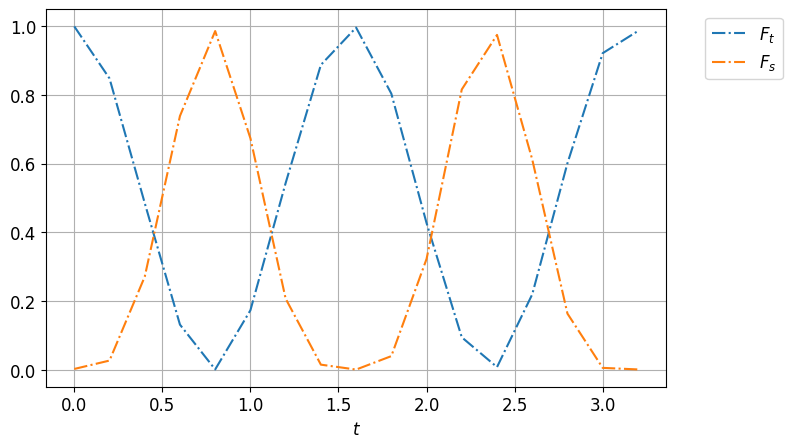

In [46]:
plt.figure(figsize = (8,5), dpi = 100)
plt.plot(t, Ft, '-.', label = r'$F_{t}$'); plt.plot(t, Fs, '-.', label = r'$F_{s}$')
# plt.plot(t, Fe, '-.', label = r'$F_{e}$')
plt.xlabel(r'$t$'); plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid(); plt.show()
# a simulação funcionou para j = 1 (demora um pouco para executar)
# a simulação funcionou tb para j = 2

## Sobre o chip jakarta
<img src = 'fig_jakarta_chip.png' width = '600'>

In [65]:
device = provider.get_backend('ibmq_jakarta')
jakarta_info = backend_monitor(device); print(jakarta_info)

ibmq_jakarta
Configuration
-------------
    n_qubits: 7
    operational: True
    status_msg: active
    pending_jobs: 3
    backend_version: 1.0.25
    basis_gates: ['id', 'rz', 'sx', 'x', 'cx', 'reset']
    local: False
    simulator: False
    open_pulse: False
    timing_constraints: {'acquire_alignment': 16, 'granularity': 16, 'min_length': 64, 'pulse_alignment': 1}
    measure_esp_enabled: False
    backend_name: ibmq_jakarta
    supported_instructions: ['setf', 'u2', 'sx', 'id', 'delay', 'u1', 'cx', 'x', 'play', 'u3', 'acquire', 'reset', 'shiftf', 'rz', 'measure']
    n_registers: 1
    url: None
    coupling_map: [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 5], [4, 5], [5, 3], [5, 4], [5, 6], [6, 5]]
    dtm: 0.2222222222222222
    conditional_latency: []
    default_rep_delay: 250.0
    pulse_num_channels: 9
    allow_q_object: True
    processor_type: {'family': 'Falcon', 'revision': '5.11', 'segment': 'H'}
    supported_features: ['q', 'o', 'b', 'j']
    meas_levels

Qubits [Name / Freq / T1 / T2 / RZ err / SX err / X err / Readout err]
----------------------------------------------------------------------
    Q0 / 5.23636 GHz / 108.34978 us / 47.62213 us / 0.00000 / 0.00031 / 0.00031 / 0.01840 
    Q1 / 5.01417 GHz / 144.48989 us / 24.98729 us / 0.00000 / 0.00021 / 0.00021 / 0.02210 
    Q2 / 5.10773 GHz / 196.25066 us / 27.15244 us / 0.00000 / 0.00024 / 0.00024 / 0.01730 
    Q3 / 5.17838 GHz / 127.03798 us / 25.98137 us / 0.00000 / 0.00047 / 0.00047 / 0.01930 
    Q4 / 5.21337 GHz / 137.57882 us / 54.69830 us / 0.00000 / 0.00019 / 0.00019 / 0.01500 
    Q5 / 5.06323 GHz / 113.94138 us / 46.81237 us / 0.00000 / 0.00032 / 0.00032 / 0.03890 
    Q6 / 5.29997 GHz / 80.63977 us / 23.83325 us / 0.00000 / 0.00034 / 0.00034 / 0.03300 

Multi-Qubit Gates [Name / Type / Gate Error]
--------------------------------------------
    cx5_4 / cx / 0.00826
    cx4_5 / cx / 0.00826
    cx1_3 / cx / 0.01690
    cx3_1 / cx / 0.01690
    cx6_5 / cx / 0.00951
    cx

## Resultados que interessam para o desafio
"You are to time evolve the state 
$$|110\rangle$$ to time 
$$t=\pi$$
under the $XXX$ Heisenberg model Hamiltonian $H_{\text{heis3}}$ as defined in Section 1. This will be done on the 
$$\text{ibmq_jakarta}$$
quantum computer. From left to right, the qubits in $|110\rangle$ correspond to ibmq_jakarta's
$$\text{qubits 5, 3, and 1.}$$
The evolution must be done using Trotterization with at least 
$$4 \text{ steps } (n\geq4)."$$

"You will be judged on the clarity, originiality, and creativity of your solution, as well as the fidelity of the evolved state at time $t=\pi$ using [state tomography]".

"Ibmq_jakarta's qubits 0, 2, 4, and 6 will not be evaluated by the state tomography calculation, so you may use them as you wish."

"You do not need to follow the same decomposition given in the example above, but your solution must be a Trotterization of $U_{\text{heis3}}(t)$ with at least 4 steps ($n\geq4$)."

## Usando as simetrias do hamiltoniano
Usar efeito Zenão para cancelar erros através de repeditas aplicações de operações de simetria (rotações locais).

## Usando pulsos
Ver como pulsos são usados, o que se poder fazer com eles e como usar redes neurais artificiais pra a escolha das sequências de pulsos a serem aplicados de forma a diminuir os erros de implementação.

Fazer tomografia de processos para identificar erros sistemáticos de portas e do circuito como um todo e utilizar pulsos adicionais para corrigir esses erros.

Usar sequência de pulsos aleatórios que se cancelam no final da evolução.

### Referências
* Yuan Su, Trotterization and Trotter error (https://youtu.be/KPofFJc57gU).
* IBM QUANTUM AWARDS: OPEN SCIENCE PRIZE 2021 (https://ibmquantumawards.bemyapp.com/#/event?email_confirmed=true).